<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/ResNeXt_cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNeXt

元論文 >> ResNeXt: Aggregated Residual Transformations for Deep Neural Networks https://arxiv.org/abs/1611.05431

ResNetのblockを改良したもの networkをチャンネルで細かく分けてそれぞれconvする構造

| ResNet block | ResNeXt block |
|:---:|:---:|
| <img src="images/resnet_block.png" height=200> |  <img src="images/resnext_block.png" height=200> |

ResNeXtのblockを等価的に1 > 2 > 3と変換することができる

|ResNeXt block 1 | ResNeXt block 2 | ResNeXt block 3 |
|:---:|:---:|:---:|
| <img src="images/resnext_block.png" height=200> |  <img src="images/resnext_block2.png" height=200> | <img src="images/resnext_block3.png" height=200>  |

Group convolutionの中身はこれ グループの数だけそれぞれconvをして、最後にチャンネル方向に連結する

<img src="images/group_conv.png" height=200> 

In [1]:
!pip install -q --upgrade albumentations==0.5.1

     |████████████████████████████████| 81kB 5.5MB/s 
     |████████████████████████████████| 36.7MB 85kB/s 
     |████████████████████████████████| 952kB 52.7MB/s 


# torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

def get_model(out_dim, dropout=0.5, pretrained=True):
    model = models.resnext101_32x8d(pretrained=True)
    del model.fc
    
    model.fc = nn.Sequential(
        nn.Linear(2048, out_dim),
    )

    return model

# scratch

## ResNeXt50

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResNeXt50(torch.nn.Module):
    def __init__(self, out_dim):
        super(ResNeXt50, self).__init__()

        class ResNeXtBlock(torch.nn.Module):
            def __init__(self, in_f, f_1, out_f, stride=1, cardinality=32):
                super(ResNeXtBlock, self).__init__()

                self.stride = stride
                self.fit_dim = False
                
                self.block = torch.nn.Sequential(
                    torch.nn.Conv2d(in_f, f_1, kernel_size=1, padding=0, stride=stride),
                    torch.nn.BatchNorm2d(f_1),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(f_1, f_1, kernel_size=3, padding=1, stride=1, groups=cardinality),
                    torch.nn.BatchNorm2d(f_1),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(f_1, out_f, kernel_size=1, padding=0, stride=1),
                    torch.nn.BatchNorm2d(out_f),
                    torch.nn.ReLU(),
                )

                if in_f != out_f:
                    self.fit_conv = torch.nn.Conv2d(in_f, out_f, kernel_size=1, padding=0, stride=1)
                    self.fit_dim = True
            
            def forward(self, x):
                res_x = self.block(x)
                
                if self.fit_dim:
                    x = self.fit_conv(x)
                
                if self.stride == 2:
                    x = F.max_pool2d(x, 2, stride=2)
                    
                x = torch.add(res_x, x)
                x = F.relu(x)
                return x
        
        self.module = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d([3, 3], padding=1, stride=2),
            ResNeXtBlock(64, 128, 256), # block2
            ResNeXtBlock(256, 128, 256),
            ResNeXtBlock(256, 128, 256),
            ResNeXtBlock(256, 256, 512, stride=2), # block3
            ResNeXtBlock(512, 256, 512),
            ResNeXtBlock(512, 256, 512),
            ResNeXtBlock(512, 256, 512),
            ResNeXtBlock(512, 512, 1024, stride=2), # block4
            ResNeXtBlock(1024, 512, 1024),
            ResNeXtBlock(1024, 512, 1024),
            ResNeXtBlock(1024, 512, 1024),
            ResNeXtBlock(1024, 512, 1024),
            ResNeXtBlock(1024, 512, 1024),
            ResNeXtBlock(1024, 1024, 2048, stride=2), # block5
            ResNeXtBlock(2048, 1024, 2048),
            ResNeXtBlock(2048, 1024, 2048),
        )

        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

        self.linear = torch.nn.Linear(2048, out_dim)
        
        
    def forward(self, x):
        x = self.module(x)
        x = self.avg_pool(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        return x

## ResNeXt101

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResNeXt101(torch.nn.Module):
    def __init__(self, out_dim):
        super(ResNeXt101, self).__init__()

        class ResNeXtBlock(torch.nn.Module):
            def __init__(self, in_f, f_1, out_f, stride=1, cardinality=32):
                super(ResNeXtBlock, self).__init__()

                self.stride = stride
                self.fit_dim = False
                
                self.block = torch.nn.Sequential(
                    torch.nn.Conv2d(in_f, f_1, kernel_size=1, padding=0, stride=stride),
                    torch.nn.BatchNorm2d(f_1),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(f_1, f_1, kernel_size=3, padding=1, stride=1, groups=cardinality),
                    torch.nn.BatchNorm2d(f_1),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(f_1, out_f, kernel_size=1, padding=0, stride=1),
                    torch.nn.BatchNorm2d(out_f),
                    torch.nn.ReLU(),
                )

                if in_f != out_f:
                    self.fit_conv = torch.nn.Conv2d(in_f, out_f, kernel_size=1, padding=0, stride=1)
                    self.fit_dim = True
            
            def forward(self, x):
                res_x = self.block(x)
                
                if self.fit_dim:
                    x = self.fit_conv(x)
                
                if self.stride == 2:
                    x = F.max_pool2d(x, 2, stride=2)
                    
                x = torch.add(res_x, x)
                x = F.relu(x)
                return x

        block = []
        for _ in range(22):
            block.append(ResNeXtBlock(1024, 512, 1024))
        resblock4s = torch.nn.Sequential(*block)
        
        self.module = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d([3, 3], padding=1, stride=2),
            ResNeXtBlock(64, 128, 256), # block2
            ResNeXtBlock(256, 128, 256),
            ResNeXtBlock(256, 128, 256),
            ResNeXtBlock(256, 256, 512, stride=2), # block3
            ResNeXtBlock(512, 256, 512),
            ResNeXtBlock(512, 256, 512),
            ResNeXtBlock(512, 256, 512),
            ResNeXtBlock(512, 512, 1024, stride=2), # block4
            resblock4s,
            ResNeXtBlock(1024, 1024, 2048, stride=2), # block5
            ResNeXtBlock(2048, 1024, 2048),
            ResNeXtBlock(2048, 1024, 2048),
        )

        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

        self.linear = torch.nn.Linear(2048, out_dim)
        
        
    def forward(self, x):
        x = self.module(x)
        x = self.avg_pool(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        return x

# Import

In [5]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [6]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# prepare data

In [7]:
train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
train_Xs = train_ds.data
train_ys = np.array(train_ds.targets)

class CifarDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

Extracting ./cifar-10-python.tar.gz to ./


In [8]:
transforms_train = A.Compose([
    A.RandomResizedCrop(IN_HEIGHT, IN_WIDTH, scale = (0.9,1.0),ratio = (0.9,1.1),p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1,val_shift_limit=0.1,p=0.2),
    A.RandomBrightnessContrast(brightness_limit = (-0.2,0.2), contrast_limit = (-0.1,0.1), p=0.2),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [12]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_ds.data, train_ds.targets, train_ds.targets)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds.data, train_ds.targets)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    val_cv_loss = []
    val_cv_accuracy = []
    
    val_cv_labels = []
    val_cv_preds = []

    EPOCH = 30
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = CifarDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = CifarDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=256, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=256, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        target_n = 1
        
        #---
        # model
        #---
        # model = get_model(out_dim=10, pretrained=True, dropout=0.5)
        model = ResNeXt50(out_dim=10)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss(reduction="sum")
        # criterion = nn.BCELoss(reduction="sum")
        # optimizer = optim.SGD(model.parameters(), lr=0.01)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        # lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[50], gamma=0.1, last_epoch=-1)
    
        #---
        # epoch
        #---
        for epoch in range(EPOCH):

            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs = model(xs)
             
                loss = criterion(outputs, ys)
                        
                loss = loss / train_n
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += (predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)
            
            train_accuracy = correct / total
            train_accuracies.append(train_accuracy)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs = model(xs)

                    loss = criterion(outputs, ys)
                        
                    val_loss += loss.item() / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += (predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)
            
            val_accuracy = val_correct / val_total
            val_accuracies.append(val_accuracy)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} acc:{train_accuracy:.4f}  [val]loss:{val_loss:.4f} acc:{val_accuracy:.4f}  [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

#             lr_scheduler.step()


            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

        #---
        # store last val loss and accuracy
        #---
        val_cv_loss.append(val_loss)
        val_cv_accuracy.append(val_accuracy)
        
        val_cv_labels.extend(val_labels)
        val_cv_preds.extend(val_preds)
           
        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()
        
    
    #---
    # display fold score
    #---
    val_cv_loss = np.array(val_cv_loss)
    val_cv_accuracy = np.array(val_cv_accuracy)
    
    print("all folds score")
    print(f"total loss:{val_cv_loss.mean():.6f}, accuracy:{val_cv_accuracy.mean():.6f}")
    for i in range(FOLD_N):
        print(f"fold{i + 1}/{FOLD_N} loss:{val_cv_loss[i]:.6f}, accuracy:{val_cv_accuracy[i]:.6f}")
        
    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":val_cv_labels, "pred":val_cv_preds})
    print()
    print("cross table")
    display(pd.crosstab(res_df["label"], res_df["pred"]))
        
    return train_models, train_model_paths

StratifiedKFold fold:1/2
train_N=25000, val_N=25000
fold:1 epoch:1/30 [tra]loss:3.0918 acc:0.1585  [val]loss:2.6408 acc:0.1932  [time]total:29.28sec tra:24.95sec val:4.34sec
fold:1 epoch:2/30 [tra]loss:2.0943 acc:0.2350  [val]loss:1.9607 acc:0.2564  [time]total:28.86sec tra:24.58sec val:4.28sec
fold:1 epoch:3/30 [tra]loss:1.9913 acc:0.2709  [val]loss:1.8505 acc:0.3096  [time]total:28.71sec tra:24.37sec val:4.34sec
fold:1 epoch:4/30 [tra]loss:2.0000 acc:0.2956  [val]loss:2.0120 acc:0.3140  [time]total:28.81sec tra:24.47sec val:4.34sec
fold:1 epoch:5/30 [tra]loss:1.9635 acc:0.3218  [val]loss:1.8316 acc:0.3139  [time]total:28.79sec tra:24.45sec val:4.34sec
fold:1 epoch:6/30 [tra]loss:1.9812 acc:0.3247  [val]loss:3.3246 acc:0.3577  [time]total:28.87sec tra:24.52sec val:4.35sec
fold:1 epoch:7/30 [tra]loss:1.9439 acc:0.3263  [val]loss:1.8163 acc:0.3245  [time]total:28.91sec tra:24.55sec val:4.36sec
fold:1 epoch:8/30 [tra]loss:1.9691 acc:0.3222  [val]loss:6.5249 acc:0.2491  [time]total:28.79s

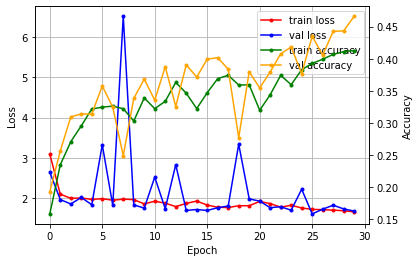

StratifiedKFold fold:2/2
train_N=25000, val_N=25000
fold:2 epoch:1/30 [tra]loss:3.0740 acc:0.1576  [val]loss:3.7884 acc:0.2114  [time]total:28.00sec tra:23.71sec val:4.29sec
fold:2 epoch:2/30 [tra]loss:2.0639 acc:0.2452  [val]loss:2.7741 acc:0.2703  [time]total:27.88sec tra:23.56sec val:4.32sec
fold:2 epoch:3/30 [tra]loss:1.9773 acc:0.2918  [val]loss:2.7762 acc:0.2924  [time]total:28.03sec tra:23.72sec val:4.31sec
fold:2 epoch:4/30 [tra]loss:1.9305 acc:0.3198  [val]loss:2.1604 acc:0.3226  [time]total:27.98sec tra:23.65sec val:4.33sec
fold:2 epoch:5/30 [tra]loss:1.8907 acc:0.3292  [val]loss:2.2192 acc:0.3284  [time]total:28.02sec tra:23.68sec val:4.33sec
fold:2 epoch:6/30 [tra]loss:1.8532 acc:0.3520  [val]loss:1.9936 acc:0.3644  [time]total:28.05sec tra:23.73sec val:4.32sec
fold:2 epoch:7/30 [tra]loss:1.8155 acc:0.3636  [val]loss:1.8439 acc:0.3822  [time]total:27.94sec tra:23.61sec val:4.33sec
fold:2 epoch:8/30 [tra]loss:1.7882 acc:0.3764  [val]loss:5.6590 acc:0.3927  [time]total:27.83s

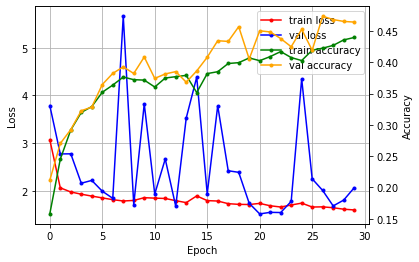

all folds score
total loss:1.869298, accuracy:0.465220
fold1/2 loss:1.674039, accuracy:0.466200
fold2/2 loss:2.064556, accuracy:0.464240

cross table


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,2418,424,345,105,117,285,111,145,818,232
1,199,3552,58,104,13,224,182,110,147,411
2,578,194,1307,310,836,665,653,295,120,42
3,150,200,243,1410,202,1594,843,160,118,80
4,270,71,381,386,1976,430,955,392,103,36
5,127,168,203,926,250,2449,471,259,108,39
6,48,129,175,312,301,229,3659,89,29,29
7,179,207,168,456,468,989,431,1924,53,125
8,744,539,60,143,75,256,87,36,2843,217


In [13]:
train_models, train_model_paths = train()

# Test

In [14]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data
    test_ys = np.array(test_ds.targets)

    dataset_test = CifarDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    preds = []
    correct = 0

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            _preds = np.zeros([len(ys), 10])

            for model in train_models:
                model_preds = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
                _preds += model_preds / model_num

            _preds = _preds.argmax(axis=1)

            preds.extend(_preds)

            correct += sum(ys.numpy() == _preds)

    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":test_ys, "pred":preds})
    print()
    print("cross table")
    cross = pd.crosstab(res_df["label"], res_df["pred"])

    accuracy = correct / len(test_ys)
    print(f"accuracy = {accuracy:.4f} ({correct} / {len(test_ys)})")

    display(cross)


test(train_models)

Files already downloaded and verified

cross table
accuracy = 0.4864 (4864 / 10000)


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,541,73,60,9,13,51,26,31,156,40
1,34,727,8,20,1,48,36,19,29,78
2,114,30,233,68,177,145,146,63,21,3
3,32,34,39,279,34,343,175,24,28,12
4,43,15,61,60,403,85,228,71,29,5
5,17,35,47,157,39,541,94,39,23,8
6,5,22,45,45,41,47,775,14,5,1
7,40,31,25,76,69,222,77,425,12,23
8,131,111,13,42,12,56,15,10,578,32
